### <center>  Machine Learning for Developers (MLDP)</center>
### <center>  Individual Assignment</center>

Data taken from: <br>
https://www.kaggle.com/datasets/blastchar/telco-customer-churn<br>
Which is a subset of the dataset taken from:<br>
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

Since the dataset telecom company is unknown, i will call it telecom X

In [210]:
# data wrangling
import pandas as pd
import numpy as np

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno

In [211]:
churn_df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.shape

(7043, 21)

In [212]:
churn_df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

Features can be separated into 3 categories:
- Demographic info about customers – gender, age range, and if they have Partners and Dependents
- Services that each customer has signed up for – PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
- Customer account information – tenure, Contract, PaymentMethod, PaperlessBilling, MonthlyCharges, TotalCharges
- Whether customer have left within the last month - Churn

In [213]:
cust_services = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
cust_account = ["tenure", "Contract", "PaymentMethod", "PaperlessBilling", "MonthlyCharges", "TotalCharges"]
categorical_features = ["Contract", "PaymentMethod", "PaperlessBilling","gender", "Partner", "Dependents", "SeniorCitizen","PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
num_features = ["tenure", 'MonthlyCharges', 'TotalCharges']

### Data Preprocessing

#### Check for Duplicates

In [214]:
before_dup = churn_df.duplicated().sum()
churn_df.drop_duplicates(inplace=True)
aft_dup = churn_df.duplicated().sum()
print(f"Before removing duplicates: {before_dup}\nAfter removing duplicates: {aft_dup}")

Before removing duplicates: 0
After removing duplicates: 0


#### Check for anomalous values

In [215]:
for column in churn_df:
    if churn_df[column].dtypes=='object':
        print(f'{column}: {churn_df[column].unique()}') 

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


#### Remove missing values

Since there are " " values in TotalCharges, set error to coerce so the string value in TotalCharges changes to a missing value

In [216]:
churn_df.TotalCharges = pd.to_numeric(churn_df.TotalCharges, errors='coerce')
churn_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Since there are only 11 columns, dropping them would unlikely affect EDA and data modelling much

In [217]:
churn_df.dropna(subset=["TotalCharges"], how="any", inplace=True)

Since there are a few columns with "No internet service", which also implies "No", replace values with similar meanings, keeping these would inflate dimensionality more later on after one-hot encoding

In [218]:
churn_df.replace('No internet service','No',inplace=True)
churn_df.replace('No phone service','No',inplace=True)

### Data Transformation

Creating a new column "Customer Services", a discrete numerical column that shows the number of services the customer has signed up for

In [219]:
# pass a row into function which iterates through customer services columns and count number of services customer signed up
def sum_cust_services(row):
    max_cust_services = len(cust_services)
    # cust_services is a list of the column names for respective service columns 
    for i in cust_services:
        if row[i] == "No": 
            max_cust_services -= 1
    return max_cust_services
churn_df["Customer Services"] = 0 # initialize column before replacement

In [220]:
for row_index in range(0, churn_df.shape[0]):
    churn_df["Customer Services"].iloc[row_index]  = sum_cust_services(churn_df.iloc[row_index])

C:\Users\addsw\AppData\Local\Temp\ipykernel_8628\569535102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df["Customer Services"].iloc[row_index]  = sum_cust_services(churn_df.iloc[row_index])


Change SeniorCitizen and Churn column values from binary to string, easier to see for exploratory data analysis

In [221]:
churn_df["SeniorCitizen"].replace(to_replace=0, value="Not Senior", inplace=True)
churn_df["SeniorCitizen"].replace(to_replace=1, value="Senior", inplace=True)
churn_df["Churn"].replace(to_replace="Yes", value="Churned", inplace=True)
churn_df["Churn"].replace(to_replace="No", value="Not Churned", inplace=True)

## Exploratory Data Anaylsis 

### 1. Customer Account Information: Focus on tenure & contract

1.i) Distribution of tenure among customers

Text(0.5, 1.0, 'Tenure customer distribution')

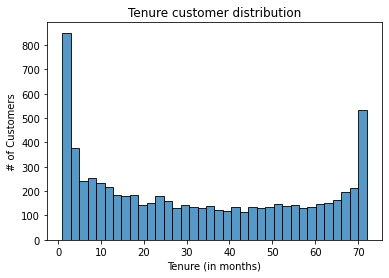

In [222]:
tenure_dist = sns.histplot(churn_df["tenure"], kde=False, kde_kws={'linewidth': 4}, bins=36)
tenure_dist.set_ylabel('# of Customers')
tenure_dist.set_xlabel('Tenure (in months)')
tenure_dist.set_title("Tenure customer distribution")

It is noticible that there have been quite many customers for about 1-3 months (approximately), and > 70months. It is also quite notable that every month interval, for the next 2 or so months, it is the highest for that 10th interval. This is most likely due to the contracts of customers, most customers with only 1-3 months tenure likely because of the month-to-month contract, the increase of customers after 2 or so months every 10th interval was likely due to the one-year and two-year contracts (12/24-month interval)

1.ii) Comparing number of customers by their tenure, among the 3 different contracts 

c:\Users\addsw\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Two Year Contract')

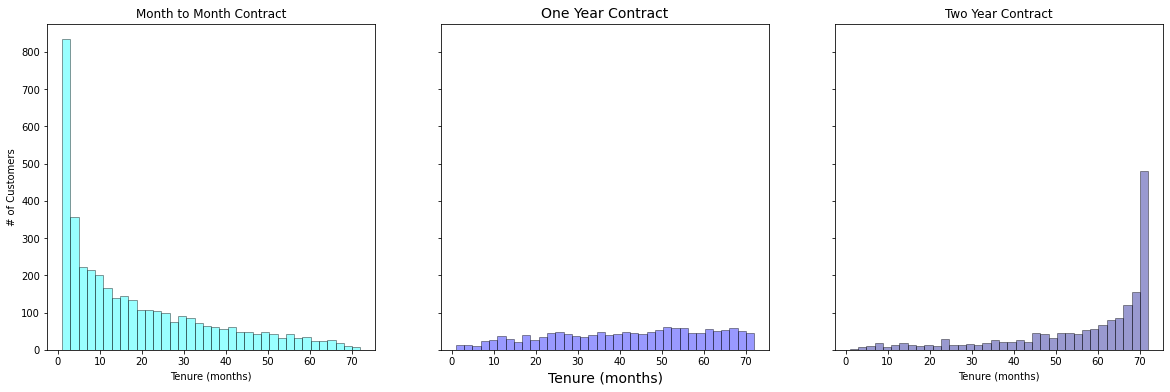

In [223]:
# initialize figure
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(churn_df[churn_df['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'cyan',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')


ax = sns.distplot(churn_df[churn_df['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'blue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(churn_df[churn_df['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

Distribution of customers among contracts:
- Most customers opted for the month to month contract
- The one year and two year contract have around the same number of people opted
<br><br>
Majority of customers who signed up for month-to-month contract stayed with the company for 1-3 months, while most of the customers with 2 year contracts tend to last for more than about 65 to 70 months, even though 2 year contracts are only 24 months long, which implies that customers are more likely to recontract with telecom X, compared to one year contract and month-to-month contract.

1.iii) Trend between tenure and the number of services a customer subscribed

In [224]:
# number of services includes
cust_services

['PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

Text(0.5, 1.0, 'Tenure by number of services')

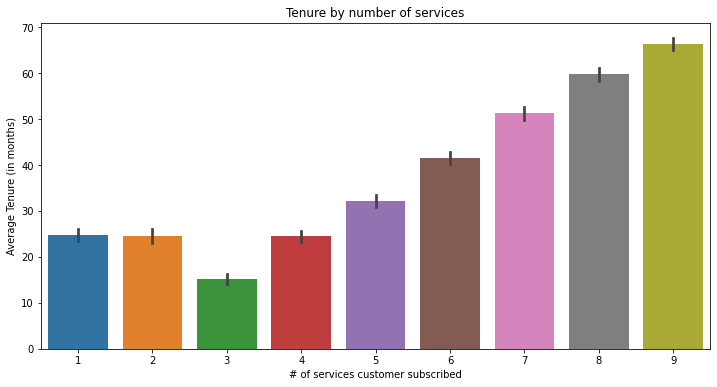

In [225]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (12,6))

avg_tenure_by_services = [] 


ax = sns.barplot(x=churn_df["Customer Services"], y=churn_df["tenure"], ax=ax1)
ax.set_ylabel('Average Tenure (in months)')
ax.set_xlabel('# of services customer subscribed')
ax.set_title('Tenure by number of services')

Every customer has at least 1 service subscribed
<br>
The number of services the customer subscribed to generally follows a direct proportion with customer's average tenure in months, with the exception of customers with 3 services subscribed. This means encouraging customers to sign up for more services could increase customer retention with telecom X. 

### 2. Analysing customer demographics

2.i) Distribution of gender and senior citizens in customers

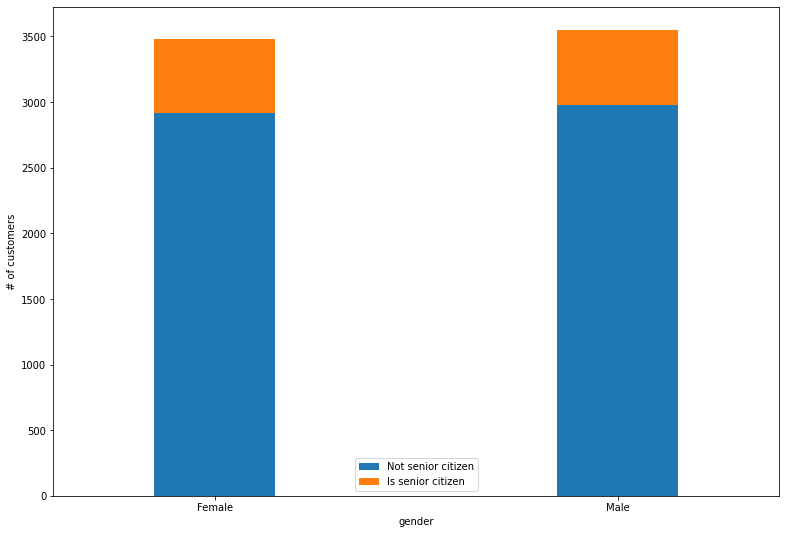

In [226]:
demographic_df = churn_df.groupby(['SeniorCitizen','gender']).size().unstack()

ax_demo = demographic_df.T.plot(kind='bar',width = 0.3, stacked = True, rot = 0, figsize = (13,9))

ax_demo.set_ylabel('# of customers')
ax_demo.set_title('')
ax_demo.legend(["Not senior citizen", "Is senior citizen"])

plt.show()

Gender distribution in customers are almost the same (~ 50% for both male and female) <br>
Noticibly, both the distribution for senior citizens are also about evenly distributed among both genders <br>
Most of our customers are younger people 

2.ii) Demographic of customers with partners and dependents

### 3. Analysing our predictor variable, churn, and relationship with other important variables  

3.i) Finding out customer churn rate

In [227]:
churn_percentage = churn_df['Churn'].value_counts()*100.0 /len(churn_df)
churn_percentage

Not Churned    73.421502
Churned        26.578498
Name: Churn, dtype: float64

The churn rate is 26.57%, which is a large percentage, considering 1 in every 4 customers leave telecom X. The data could be skewed towards a higher churn rate, when sampling this subset of data. This is important to note as data modelling on a skewed dataset could lead to more false negatives, but we will make do with the data we have

3.ii) Relationship between tenure and churn (using boxplot)

Text(0.5, 1.0, 'Distribution of customers who churn by their tenure')

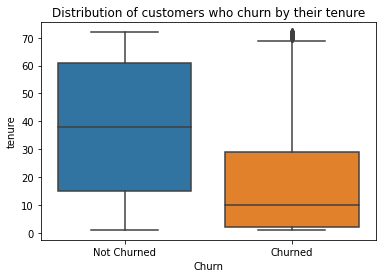

In [228]:
sns.boxplot(x = churn_df["Churn"], y = churn_df["tenure"]).set_title("Distribution of customers who churn by their tenure")

Customers who did not churn generally stays with telecom X longer, however there are some anomalies among those who churned but has a high tenure with telecom X

3.iii) Comparing  churn between senior citizens and the younger people

Text(0.5, 1.0, 'Comparing churn rate between seniors and young')

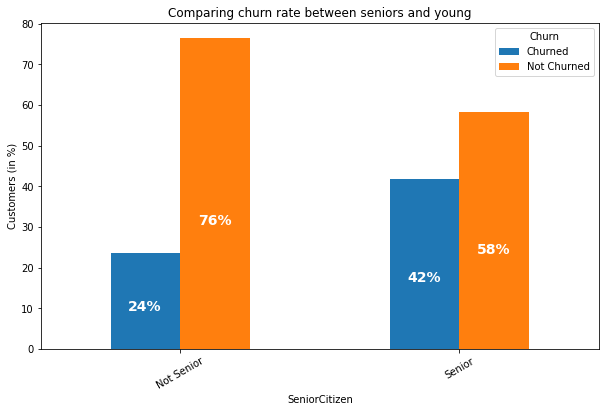

In [229]:
# get percentage between groups
seniority_churn = churn_df.groupby(['SeniorCitizen','Churn']).size().unstack()
seniority_churn_percentage = seniority_churn.T*100.0 / seniority_churn.T.sum()
seniority_churn_percentage = seniority_churn_percentage.T

# plot side by side bar graph
ax = seniority_churn_percentage.plot(kind = "bar", rot="30", figsize = (10,6))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height), # annotate each bar graph at 40% height
                color = 'white',
               weight = 'bold',size =14)
ax.set_ylabel("Customers (in %)")
ax.set_title("Comparing churn rate between seniors and young")

A higher percentage of seniors churn from telecom X compared to the younger population, the churn rate for seniors is almost 2x of the churn rate compared to those who are not seniors

3.iv) Trends comparing customer monthly charges and total charges with churn using a probability density function  

Text(0.5, 1.0, 'Distribution of total charges by churn')

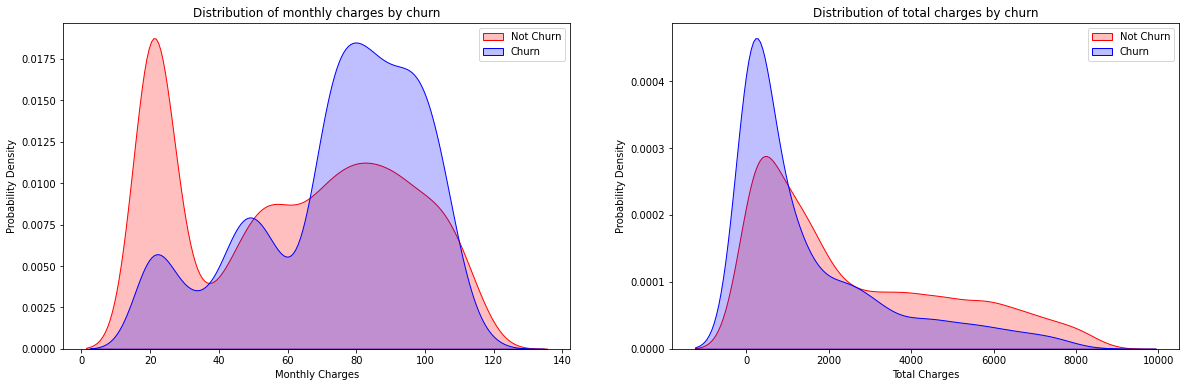

In [230]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20,6))

ax = sns.kdeplot(churn_df["MonthlyCharges"][(churn_df["Churn"] == 'Not Churned') ],
                ax=ax1, color="Red", shade = True)
ax = sns.kdeplot(churn_df["MonthlyCharges"][(churn_df["Churn"] == 'Churned') ],
                ax =ax1, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"])
ax.set_ylabel('Probability Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

ax = sns.kdeplot(churn_df["TotalCharges"][(churn_df["Churn"] == 'Not Churned')],
                ax=ax2,color="Red", shade =True)
ax = sns.kdeplot(churn_df.TotalCharges[(churn_df["Churn"] == 'Churned')],
                ax =ax2, color="Blue", shade=True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

Generally, for monthly charges, customers who pay a lower monthly charge are more likely to not churn, compared to customers who pay > 70 are more likely to churn <br><br>
For total charges, there is not much difference between whether customers will churn or not, however, it is notable that customers who paid < 1700 are more likely to churn, those who did not churn are a little more skewed towards higher total charges compared to those who churned

## Data Modelling<br>
1. Features Selection
2. Scaling and encoding data 
3. Choosing machine learning models
4. Assessing model performance
5. Preventing overfitting 

In [325]:
# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# I will be using mean absolute error as cost function to evaluate the models
from sklearn.metrics import mean_absolute_error, accuracy_score

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,cross_val_score

# initialize models
LR = LogisticRegression()
DT = DecisionTreeClassifier()
KNN = KNeighborsClassifier()
NB = GaussianNB()
RFC = RandomForestClassifier()

stratified_kfold = StratifiedKFold(n_splits=4)
kfold = KFold(5)

### Features Selection

Removing ID column, since it has no meaning, and customer services since it is not mutually exclusive or an independent event (as we added it ourselves previously for EDA)

In [232]:
chi_df = churn_df.drop(columns=["customerID", "Customer Services"])

#### 1. Chi-Square Test<br>
Targeting categorical features against categorical predictor

In [233]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

Changing categorical features to a nominal field with each value representing a number, this is needed as chi2 cannot interpret categorical string values

In [234]:
label_encoder = LabelEncoder()
for i in categorical_features:
    chi_df[i] = label_encoder.fit_transform(chi_df[i])

y = chi_df["Churn"]
X = chi_df.drop(["Churn"], axis=1,inplace=False)

In [235]:
chi_scores = chi2(X,y)

In [236]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

Text(0.5, 0, 'Features')

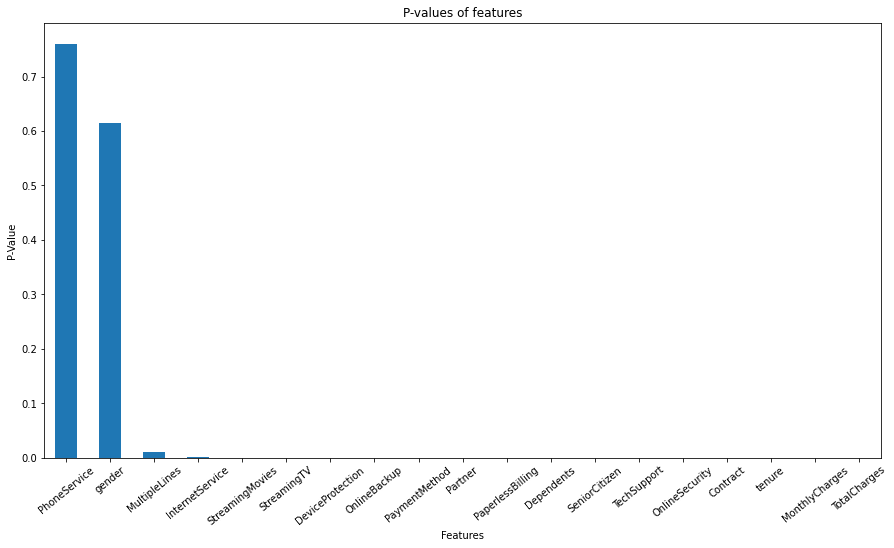

In [237]:
plt.figure(figsize=(15,8))
p_values.plot.bar()
plt.xticks(rotation= 39)
plt.title("P-values of features")
plt.ylabel("P-Value")
plt.xlabel("Features")

As PhoneService and gender has an extremely high P value, I will be removing them as they do not have much statistical significance towards whether the customer will churn. 

In [238]:
modelling_df = churn_df.drop(columns= ["customerID", "PhoneService", "gender", "Customer Services"])

Since Churn is our predictor variable, converting it to a binary numeric variable 

In [239]:
modelling_df['Churn'].replace(to_replace='Churned', value=1, inplace=True)
modelling_df['Churn'].replace(to_replace='Not Churned',  value=0, inplace=True)

#### Handling categorical values

The machine learning models I will be using are unable to handle categorical value, I will be using label encoding - for columns with only yes/no values, and one-hot encoding for the rest of the categorical features 

In [244]:
for column in modelling_df:
    print(f'{column}: {modelling_df[column].unique()}') 

SeniorCitizen: ['Not Senior' 'Senior']
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


Label Encoding

In [243]:
# label encoding for yes/no columns
for i in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','MultipleLines','StreamingMovies', 'Partner', 'Dependents', 'PaperlessBilling']:
    modelling_df[i] = label_encoder.fit_transform(modelling_df[i])

One-Hot encoding

In [245]:
modelling_df = pd.get_dummies(modelling_df)
modelling_df.head()

,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,34,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0,2,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,45,0,1,0,1,1,0,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,2,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


However, our categorical values remain and we are unable to compare correlation with each other <br>
Using one-hot encoding, we are able to represent our categorical values numerically and most importantly on the same scale, 0 or 1

#### Compare correlation with other variables in respect to Churn

<AxesSubplot:>

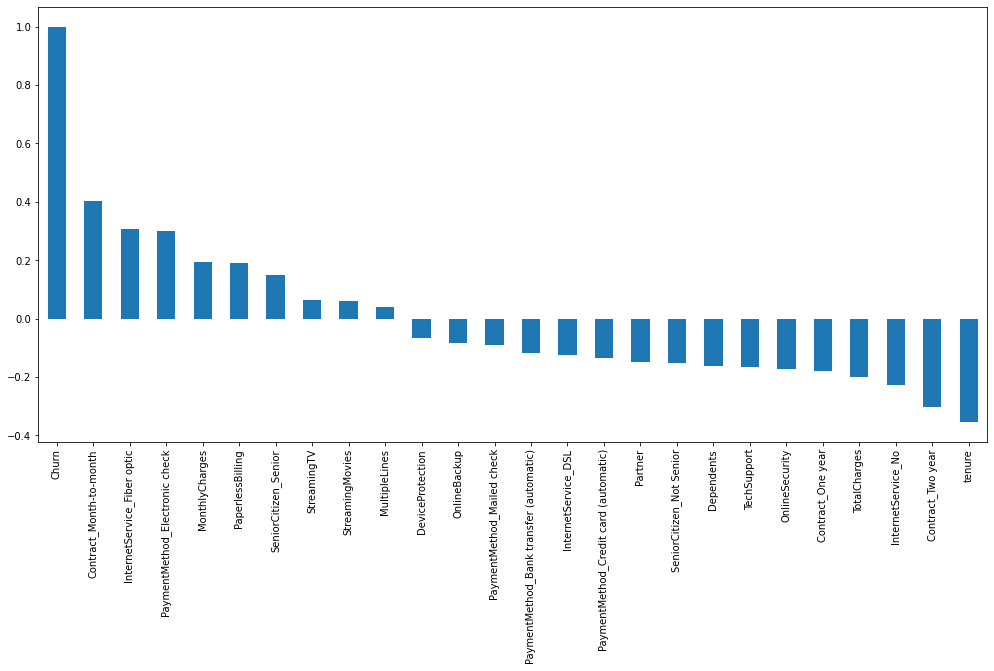

In [246]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(17,8))
modelling_df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

HoldOut Validation Approach     

#### Scaling numerical data
Scale the data to prevent introducing bias to certain features with higher values and set numerical features on the same scale<br>
Since machine learning algorithms used later like logistic regression uses gradient descent, which iteratively calculates distance between datapoints

In [247]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standardization = StandardScaler()
normalization = MinMaxScaler()

# no normalization/standardization
y = modelling_df["Churn"]
X = modelling_df.drop(["Churn"], axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# create a copy of X 
X_standardized = X
X_normalized = X

# Standardize numerical columns 
X_standardized[num_features] = standardization.fit_transform(modelling_df[num_features])
S_X_train, S_X_test, S_y_train, S_y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Normalize numerical columns
X_normalized[num_features] = normalization.fit_transform(modelling_df[num_features])
N_X_train, N_X_test, N_y_train, N_y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

3 different X and y splits are created for different algorithms
No standardization/normalization - will not be scaled since tree-based algorithms are insensitive to the scale of features<br>
Normalization is generally better for K-Nearest Neighbours (KNN) that do not assume any distribution of the data

#### Metric selection 
The goal for prediction of churn for telecom X customers is to prevent customer churn before they do happen, telecom X needs to identify correctly and as most accurately as many true positives (high precision), and minimize the number of false negatives (high recall). <br>
As we value precision and recall, we shall include f1-score which is the harmonic mean of precision & recall, which is useful as we are seeking a model which performs reasonably well across both metrics.

Model Selection: a form of naive bayes, logistic regression, K-nearest neighbours, random forest classifier & decision trees

#### K-Nearest Neighbours

As our numerical columns (tenure, monthly charges and total charges) do not follow a gaussian distribution and most likely will not (see the trends in EDA above), and K-Nearest Neighbours (KNN) do not assume any distribution of data, I will be using the standardized
<br>
As there are no straightforward 'theoretical' way of picking the best number of n_neighbours (or 'k'), I will use a brute-force approach and evaluate both the training and testing accuracies to determine which is best

In [335]:
train_accuracies = {}
test_accuracies = {}
neighbors=np.arange(1,50)
for neighbor in neighbors:
    knn=KNeighborsClassifier(n_neighbors = neighbor, n_jobs=-1)
    knn.fit(X_train,y_train)
    train_accuracies[neighbor]=knn.score(X_train,y_train)
    test_accuracies[neighbor]=knn.score(X_test,y_test)

Visualize test and training accuracies for hyperparameter tuning of n_neigbours in knn

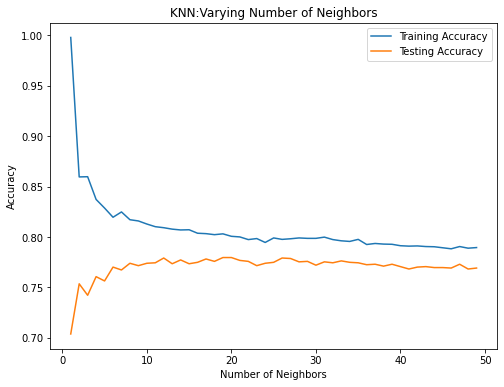

In [336]:
plt.figure(figsize=(8,6))
plt.title("KNN:Varying Number of Neighbors")
plt.plot(neighbors,train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors,test_accuracies.values(),label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [136]:
print(f"Percentage of customers who DID NOT churn: {modelling_df.Churn.value_counts()[0] / modelling_df.Churn.value_counts().sum() * 100}\nAccuracy of KNN when there are only 1 neighbour: {test_accuracies.get(1) * 100}%")

Percentage of customers who DID NOT churn: 73.42150170648463
Accuracy of KNN when there are only 1 neighbour: 71.4218009478673%


Although there are only 1 neighbour, the accuracy is still quite high, this could be due to the case of an imbalanced dataset in the churn column where the ratio of customers who churn and did not churn are around 27:73, which would explain why the accuracy despite having 1 neighbour almost fits the ratio of customers who churn or did not churn
<br><br>
Therefore, it would be wise to not use accuracy to evaluate model performance

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
knn_params={"n_neighbors":range(1,30,2),
    "weights":["uniform","distance"],
    "metric":["euclidean","manhattan","minkowski"],
    #"algorithm":["auto","ball_tree","kd_tree","brute"],
    "leaf_size":range(1,50,5)
}
#grid search
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=928)
grid_search=GridSearchCV(estimator = KNN, param_grid=knn_params, n_jobs = -1, cv = cv, scoring= "f1")
grid_results=grid_search.fit(X_train,y_train)

#### Logistic Regression

In [330]:
LR.fit(X_train,y_train)
LR_y_pred = LR.predict(X_test)
y_pred_probs = LR.predict_proba(X_test)[:,1]

c:\Users\addsw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


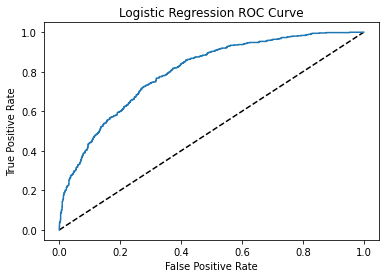

In [331]:
from sklearn.metrics import roc_curve, roc_auc_score
# false positive rates - fpr, true positive rates - tpr
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [139]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test,y_pred_probs))

0.8386671177655874


Using randomized search instead of grid search since grid search takes too long

In [334]:
# hyperparameter tuning
from sklearn.model_selection import  RandomizedSearchCV
# Create the parameter space
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 9900000),
    "fit_intercept": [True, False],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    "class_weight": ["balanced", None]
    }
]

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(LR, param_grid, cv= stratified_kfold, n_jobs= -1, random_state=928, scoring='roc_auc', n_iter=10000)

# Fit the data to the model
logreg_cv.fit(S_X_train, S_y_train)
lr_params = logreg_cv.best_params_

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(lr_params))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logreg_cv.best_score_))

c:\Users\addsw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18356 fits failed out of a total of 40000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2004 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\addsw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\addsw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\addsw\AppData\Local\Programs

Tuned Logistic Regression Parameters: {'solver': 'saga', 'penalty': 'l1', 'fit_intercept': True, 'class_weight': None, 'C': 4.0073924818019515}
Tuned Logistic Regression Best Accuracy Score: 0.8489239446860473


In [ ]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y= LR.predict(X_test) 

probs_y=LR.predict_proba(X_test) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

c:\Users\addsw\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


(0.0, 1.0)

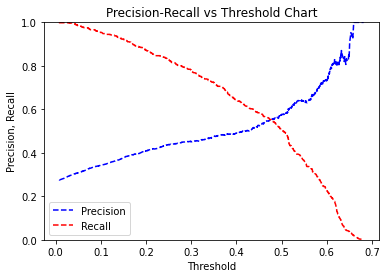

In [329]:
LR = LogisticRegression(solver=lr_params["solver"], penalty=lr_params["penalty"],max_iter=10000,fit_intercept=lr_params["fit_intercept"],C=lr_params["C"])
LR.fit(X_test, y_test)
pred_y= LR.predict(X_test) 

probs_y=LR.predict_proba(X_test) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

#### Naive Bayes

In [282]:
import sklearn.naive_bayes as NB

In [295]:
bernNB = NB.BernoulliNB() 
bernNB.fit(X_train, y_train)
bernNB.score(X_test, y_test)

0.7587677725118483

In [285]:
catNB = NB.CategoricalNB() 
catNB.fit(X_train, y_train)
catNB.score(X_test, y_test)

0.7597156398104266

#### Random Forest Classifier

As we do not know the effective range to decide how many n_estimators (number of trees random forest classifier should build), I will try to find using default parameters except for n_estimators, the stable range to start finding, so our gridsearch range is more effective taking up lesser time 

Text(0, 0.5, 'Testing Accuracy')

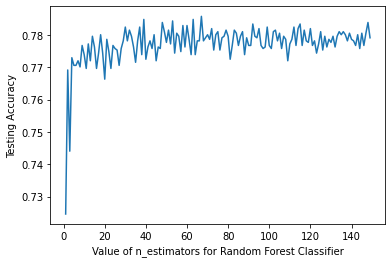

In [267]:
from sklearn.metrics import accuracy_score
scores =[]
for k in range(1, 150):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(range(1, 150), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

As the testing accuracy increases and becomes more stable after 40 n_estimators (number of trees), I will start Grid search from 40 n_estimators

Build parameters where I want GridSearch to iterate   

In [250]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 120, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators, 'max_features': max_features,'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 12, 14, 16, 18, 21, 23, 25, 27, 30, 32, 34, 36, 39, 41, 43, 45, 48, 50, 52, 54, 57, 59, 61, 63, 66, 68, 70, 72, 75, 77, 79, 81, 84, 86, 88, 90, 93, 95, 97, 99, 102, 104, 106, 108, 111, 113, 115, 117, 120], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 8], 'min_samples_split': [2, 8], 'min_samples_leaf': [1, 8], 'bootstrap': [True, False]}


In [259]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = RFC, param_grid = param_grid, cv =stratified_kfold, verbose=2, n_jobs=-1, scoring='roc_auc')

Time for fitting depends on computational power of each core and number of cores used <br>
12 cores, ~ 3593 Mhz took me around 37 seconds 

In [260]:
rf_Grid.fit(X_train, y_train)

Fitting 4 folds for each of 1600 candidates, totalling 6400 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 8],
                         'min_samples_split': [2, 8],
                         'n_estimators': [10, 12, 14, 16, 18, 21, 23, 25, 27,
                                          30, 32, 34, 36, 39, 41, 43, 45, 48,
                                          50, 52, 54, 57, 59, 61, 63, 66, 68,
                                          70, 72, 75, ...]},
             scoring='roc_auc', verbose=2)

In [253]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 21}

In [256]:
RFC.fit(X_train, y_train)

RandomForestClassifier()

Bootstrap aggregation and 

In [268]:
RFC_improved = RandomForestClassifier(bootstrap= True, max_depth= 8, min_samples_leaf=1, min_samples_split=2,n_estimators=21, max_features="auto",random_state= 928)

In [269]:
RFC.score(X_test,y_test)

0.7819905213270142

In [270]:
RFC_improved.fit(X_train, y_train)
RFC_improved.score(X_test,y_test)

0.7976303317535545